# Code submission form
모델 코드(.ipynb) 와 훈련된 weight(.pt/.pth)를 i-campus에 제출해야 합니다. 모델 코드(.ipynb)는 jupyter notebook 기반으로 빌드해야 하며, 제공되는 submission form에 맞추어서 제출해야 합니다

### Basic information
##### 팀 번호와 팀 구성원 이름을 적어주세요.
> 팀 번호<br>
이름 (학번)<br> 이름 (학번)<br> 

<span style="color:blue"> **** should be filled here **** </span>
*****************************************************************

Team 8

서재원(2019314991)

송채헌(~~~)

이지수(~~~)

*****************************************************************

### Inference 코드
빌드한 코드를 여기에 적어주세요. <br>
훈련된 weight(.pt/.pth)파일을 불러오고 오류 없이 작동되야 합니다.<br>
https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

<span style="color:blue"> **** should be filled here **** </span>
*****************************************************************

In [31]:
import torchvision.transforms as transforms
import torch, random, math, numpy as np 
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
def set_seed(seed):
    """Set the seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(2025)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# 1. Trainset
# FashionMNIST only 2nd class (T-shirt/top)
trainset = datasets.FashionMNIST(
    root      = './.data/', train = True,
    download  = True,
    transform = transforms.ToTensor(),
    )
trainset.data = trainset.data[trainset.targets == 2]
trainset.targets = trainset.targets[trainset.targets == 2]
train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = 1,
    shuffle     = True,
    num_workers = 2
)

# 2. Testset
# FashionMNIST only 2nd, 4th and 6th class (T-shirt/top, coat, shirt)
testset = datasets.FashionMNIST(
    root      = './.data/', train     = False,
    download  = True,
    transform = transforms.ToTensor(),
    )

test_label = [2,4,6] # Define actual test class that we use
actual_testdata = torch.isin(testset.targets, torch.tensor(test_label))
testset.data = testset.data[actual_testdata]
testset.targets = testset.targets[actual_testdata]

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = 1,
    shuffle     = False,
    num_workers = 2
)

In [33]:
# SSIM, MS-SSIM, Charbonnier, Gradient, TV loss with autograd-safe NaN fallback
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

# ------------------------
# Gaussian Window (for SSIM)
# ------------------------
def gaussian(window_size, sigma):
    gauss = torch.Tensor([
        math.exp(-(x - window_size//2)**2 / float(2*sigma**2))
        for x in range(window_size)
    ])
    return gauss / gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float()
    window = _2D_window.unsqueeze(0).unsqueeze(0)
    return window.expand(channel, 1, window_size, window_size).contiguous()

# ------------------------
# SSIM Loss (autograd-safe NaN fallback)
# ------------------------
def ssim_loss(img1, img2, window_size=11, eps=1e-8):
    B, C, H, W = img1.size()
    window = create_window(window_size, C).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=C)
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=C)
    mu1_sq, mu2_sq, mu1_mu2 = mu1**2, mu2**2, mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=C) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=C) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=C) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    numerator = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)
    denominator = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)

    if torch.isnan(denominator).any():
        return torch.tensor(np.inf).to(img1.device)
    ssim_map = numerator / (denominator + eps)
    return 1 - ssim_map.mean() # Mean SSIM

# ------------------------
# MS-SSIM Loss (autograd-safe NaN fallback)
# ------------------------
def ms_ssim_loss(img1, img2, levels=3):
    weights = [0.5, 0.3, 0.2]
    loss = 0.0
    for l in range(levels):
        ssim_val = ssim_loss(img1, img2)
        if torch.isnan(ssim_val) or torch.isinf(ssim_val):
            return torch.tensor(np.inf).to(img1.device)
        loss += weights[l] * ssim_val
        img1 = F.avg_pool2d(img1, kernel_size=2)
        img2 = F.avg_pool2d(img2, kernel_size=2)
    return loss

# ------------------------
# Charbonnier Loss
# ------------------------
def charbonnier_loss(x, y, epsilon=1e-3):
    return torch.mean(torch.sqrt((x - y) ** 2 + epsilon ** 2))

# ------------------------
# Gradient Loss
# ------------------------
def gradient_loss(x, y):
    def gradient(img):
        dy = torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :])
        dx = torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1])
        return dx, dy

    dx1, dy1 = gradient(x)
    dx2, dy2 = gradient(y)
    return torch.mean(torch.abs(dx1 - dx2)) + torch.mean(torch.abs(dy1 - dy2))

# ------------------------
# Total Variation (TV) Loss
# ------------------------
def tv_loss(x):
    loss = torch.mean(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + \
           torch.mean(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return loss

# ------------------------
# laplacian edge loss
# ------------------------
def laplacian_edge_loss(x, y):
    """
    Laplacian edge-based loss (no reduction).
    Returns: (B, C, H, W) loss tensor → reduction은 외부에서 수행
    """
    B, C, H, W = x.shape

    kernel = torch.tensor([[0, 1, 0],
                           [1, -4, 1],
                           [0, 1, 0]], dtype=torch.float32, device=x.device).view(1, 1, 3, 3).repeat(C, 1, 1, 1)

    x_edge = F.conv2d(x, kernel, padding=1, groups=C)
    y_edge = F.conv2d(y, kernel, padding=1, groups=C)

    loss = torch.abs(x_edge - y_edge)  # (B, C, H, W)
    return loss


In [34]:
# 3.2. custom loss function class
class FlexibleLoss(nn.Module):
    def __init__(self, mode='mse', loss_weights=None, reduction='mean'):
        super().__init__()
        self.modes = mode.lower().split('+')
        self.reduction = reduction
        self.base_weights = loss_weights if loss_weights else {m: 1.0 for m in self.modes}

    def reduce(self, x):
        if x is None:
            return None
        if not torch.isfinite(x).all():
            # print(f"[⚠️ warning] Loss contains NaN or Inf → Skipping this component")
            return None
        if self.reduction == 'none':
            return x
        elif self.reduction == 'mean':
            return x.mean()
        elif self.reduction == 'sum':
            return x.sum()

    def forward(self, x, y):
        valid_losses = {}
        active_weights = {}

        for m in self.modes:
            w = self.base_weights.get(m, 1.0)
            if w == 0:
                continue
            try:
                if m == 'mse':
                    raw = F.mse_loss(x, y, reduction='none')
                    loss = self.reduce(raw)
                elif m == 'charbonnier':
                    raw = charbonnier_loss(x, y)
                    loss = self.reduce(raw)
                elif m == 'ssim':
                    raw = ssim_loss(x, y)
                    loss = self.reduce(raw)
                elif m == 'ms-ssim':
                    raw = ms_ssim_loss(x, y)
                    loss = self.reduce(raw)
                elif m == 'gradient':
                    raw = gradient_loss(x, y)
                    loss = self.reduce(raw)
                elif m == 'tv':
                    raw = tv_loss(x)
                    loss = self.reduce(raw)
                elif m =='edge':
                    raw = laplacian_edge_loss(x, y)
                    loss = self.reduce(raw)
                elif m == 'noise':
                    continue
                else:
                    raise ValueError(f"[FlexibleLoss] Unknown loss type: {m}")
                if loss is not None:
                    valid_losses[m] = loss
                    active_weights[m] = w
            except Exception as e:
                print(f"[⚠️ warning] Loss calculation failed for {m}: {e}")
                continue
        total_loss = 0.0
        for m, loss in valid_losses.items():
            weight = active_weights[m]
            total_loss += weight * loss

        return total_loss


In [35]:
loss_fn = FlexibleLoss(
        mode="mse+gradient+edge",
        loss_weights={
            "mse": 0.5,
            "gradient": 0.4,
            "edge": 0.1
        },
        reduction="none",
    )

In [36]:
# 4. custom model class
# training 방법: new0417/swin 파일 참고 또한 config는 다음과 같음 
# SwinInspiredAE + MSEGrad_mse
'''
    "SwinInspiredAE_MSE_MSGrad": {
        "class": "SwinInspiredAutoencoder",
        "lr": 0.001,
        "batch_size": 64,
        "losses": [
            "mse+ms-ssim+gradient"
        ],
        "loss_weights": {
            "mse": 0.3,
            "ms-ssim": 1.0,
            "gradient": 0.1
        }
    }
'''

'\n    "SwinInspiredAE_MSE_MSGrad": {\n        "class": "SwinInspiredAutoencoder",\n        "lr": 0.001,\n        "batch_size": 64,\n        "losses": [\n            "mse+ms-ssim+gradient"\n        ],\n        "loss_weights": {\n            "mse": 0.3,\n            "ms-ssim": 1.0,\n            "gradient": 0.1\n        }\n    }\n'

In [37]:
import torch
import torch.nn as nn
class GatedAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2)
        )

        self.flatten = nn.Flatten()
        self.latent = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.Dropout(0.3),
            nn.Sigmoid()  # gate-like latent
        )
        self.unflatten = nn.Sequential(
            nn.Linear(256, 128 * 7 * 7),
            nn.LeakyReLU(0.2)
        )

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 7, 7)),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.2),

            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z_flat = self.flatten(z)
        z_gate = self.latent(z_flat)
        z_unflat = self.unflatten(z_gate)
        out = self.decoder(z_unflat)
        return out


In [38]:
# threshold를 찾는 함수 및 예측하는 함수    
def find_threshold(model,dataloader,loss_fn,percentile=0.95):
    """
    Find the threshold for the model on the dataset.
    여기서 loss_fn은 custom loss function을 의미한다.
    또한 percentile은 threshold를 결정하는 기준이 된다.
    dataloader는 train_loader를 의미한다.
    """
    # Calculate the loss for each sample in the dataloader
    losses = []
    for x, label in dataloader:
        x = x.to(DEVICE)
        output = model(x)
        # loss = loss_fn(output,x) # Mean loss for the batch
        loss = loss_fn(output,x).mean() # Mean loss for the batch
        losses.append(loss.item())

    # Calculate the threshold based on the specified percentile
    threshold = np.percentile(losses, percentile * 100)
    return threshold


def predict(model, dataloader, loss_fn, threshold):
    """
    Predict the labels for the dataset using the model and threshold.
    여기서 loss_fn은 custom loss function을 의미한다.
    또한 threshold는 find_threshold에서 구한 threshold를 의미한다.
    dataloader는 test_loader를 의미한다.
    """
    dic_loss = {'id':[], 'label':[], 'score':[],'normal':[]}

    for step, (x, label) in enumerate(test_loader):
        x = x.to(DEVICE)
        label = label.to(DEVICE)
        output = model(x)
        loss = loss_fn(output,x).mean() # Mean loss for the batch

        # Calculate the score based on the loss and threshold
        dic_loss['id'].append(step)
        dic_loss['label'].append(int(label)==2)
        dic_loss['score'].append(loss.item())
        if loss>threshold: dic_loss['normal'].append('0')
        else: dic_loss['normal'].append('1')
    
    return dic_loss



In [39]:
import torch
model = GatedAE()
model.load_state_dict(torch.load('./model.pth'))
model.to(DEVICE)
model.eval() # Set the model to evaluation modes

# 5. threshold 찾기
threshold = find_threshold(model, train_loader, loss_fn, percentile=0.5)
print(f"Threshold: {threshold:.4f}")


Threshold: 0.0278


In [40]:
# 6. 예측하기
dic_loss = predict(model, test_loader, loss_fn, threshold)

*****************************************************************

### 그래프 생성
리포트에 생성된 그래프(e. g., AUROC)등을 제작하는 코드를 여기에 적어주세요. AUROC의 경우 그래프와 값이 출력되야 합니다.<br>
AUROC 제작 코드는 하단 링크를 참고 해주세요.<br>
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics <br>

<span style="color:blue"> **** should be filled here **** </span>
*****************************************************************

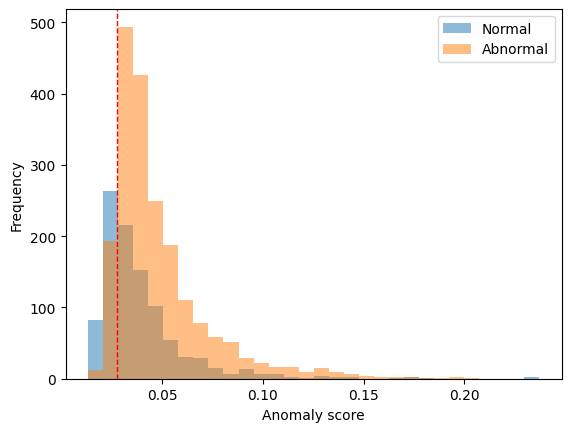

In [41]:
# Gernerating a plot
arr_label = np.array(dic_loss['label'])
arr_score = np.array(dic_loss['score'])
score_min = arr_score.min()
score_max = arr_score.max()
plt.hist(arr_score[np.where(arr_label == 1)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Normal')
plt.hist(arr_score[np.where(arr_label == 0)[0]], bins=30, range=(score_min, score_max), alpha=0.5, label='Abnormal')
plt.xlabel("Anomaly score")
plt.ylabel("Frequency")
plt.axvline(threshold,0,1, color='red',linestyle='--',linewidth=1)
plt.legend(loc='upper right')
plt.savefig("plot.png")
plt.show()

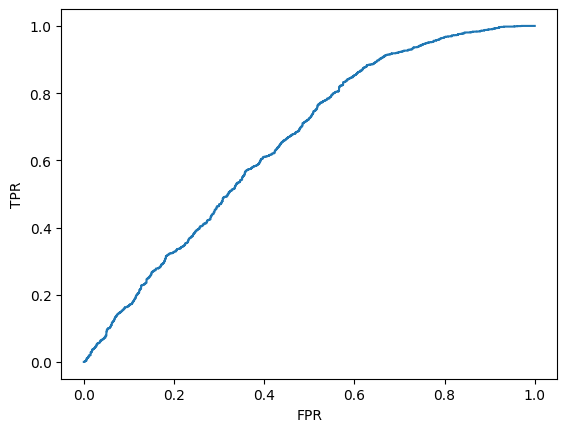

AUROC: 0.6546375


In [42]:
fpr, tpr, thresholds = roc_curve(dic_loss['label'], dic_loss['score'], pos_label=0)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("auroc.png")
plt.show()
auroc = auc(fpr, tpr)
print("AUROC: {}".format(auroc))

In [43]:
trues = np.array(dic_loss['label'])
preds = np.array(dic_loss['normal']).astype(int)
print("Accuracy: {}".format(np.mean(trues == preds)))
print("Precision: {}".format(np.sum((trues == preds) & (preds == 1)) / np.sum(preds == 1)))
print("Recall: {}".format(np.sum((trues == preds) & (preds == 1)) / np.sum(trues == 1)))
print("F1: {}".format(2 * np.sum((trues == preds) & (preds == 1)) / (np.sum(preds == 1) + np.sum(trues == 1))))


Accuracy: 0.7173333333333334
Precision: 0.6478599221789884
Recall: 0.333
F1: 0.43989431968295906


*****************************************************************

### Dataframe 생성
kaggle에 제출한 dataframe(.csv)을 제작하는 코드를 적어주세요. <br>
kaggle에 제출한 dataframe(.csv)파일과 정확도가 동일해야 합니다. <br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html

<span style="color:blue"> **** should be filled here **** </span>
*****************************************************************

In [44]:
dic_loss.pop('score',None)
dic_loss.pop('label',None)
df = pd.DataFrame.from_dict(dic_loss)
teamnumber = 8
df.to_csv("result_team{}.csv".format(teamnumber), index =False)

In [45]:
df

,id,normal
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2995,2995,0
2996,2996,0
2997,2997,0
2998,2998,0


*****************************************************************